# Programming Assingment 5 (PA5)
**Strong Recommendation**: Please use google COLAB for running your code or use a device with available GPU. 

**Google COLAB**: Simply upload the assignment notebook to your google drive and open it with google COLAB. 

**Make sure to select GPU in the setting for COLAB**. That can be done by going to 

`runtime->change runtime type->Hardware Accelerator->GPU`



## Part 1 - Multliclass Classification over images using CNN's over MNIST
Setting some hyperparameters and making sure we have a GPU

In [0]:
%matplotlib inline
import numpy as np 
import torch
import torchvision
import torchvision.transforms as transforms
import random


# Set the device to use
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Hyperparameters
num_epochs = 10
num_classes = 10
batch_size = 256

## Fixing Random Seed for Reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)


#ASSERTS
print(str(device))
assert("cuda" in str(device))

cuda:0


### Loading MNIST
Here we are loading the MNIST dataset. This dataset consists of 60,000 train data and 10,000 test data. 

Each data is 28-by-28 image which and labels are 0 to 9 (representing digits 0-9)


In [0]:
from torch.utils.data import DataLoader

# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=trans)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,num_workers=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False,num_workers=0)


##ASSERTS
assert(len(train_loader)*batch_size >= 60000)
assert(len(test_loader)*batch_size >=10000)

### Building the network
We want to have the following architecture

 

1.   2D Convolutional Layer with 32 output channels, 5-by-5 kernel, and padding of size 2, activation function RELU
2.   Maxpooling with 2-by-2 kernel and stride of size 2
3.   2D Convolutional Layer with 64 output channels, 5-by-5 kernel, and padding of size 2, activation function RELU
4.   Maxpooling with 2-by-2 kernel and stride of size 2
5.   Fully connected Layer with output size 512 with RELU activation
6.   Fully connected Layer with output of size 10 (**no activation function**)

Input:
0. Input is 28-by-28 image with only 1 channel


In [0]:
import torch.nn as nn
import torch.nn.functional as F


### ACT1-ACT9:
### Complete the code below based on the architecture described above
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2) #ACT1 
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #ACT2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64,kernel_size=5, padding=2) #ACT3
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) #ACT4

        # ACT5 compute the size of the the input for the first fully connected layer
        # You can track what happens to a 28-by-28 images when passes through the previous layers
        # you will endup with 64 channels each of size x-by-x therefore 
        # the size of input is (64*x*x) - you need to compute x and fill the code below
        self.size_linear = 64*(7*7) #ACT5
        self.fc1 = nn.Linear(self.size_linear, 512)
        self.fc2 = nn.Linear(512, 10) #ACT6
   
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x))) 
        x = self.pool2(F.relu(self.conv2(x))) #ACT7
        x = x.view(-1, self.size_linear) 
        x = self.fc1(x) #ACT8
        x = self.fc2(x) #ACT9
        return x
       
##ASSERT
with torch.no_grad():
    # making 100 random images 1 channel 28-by-28
    a = torch.rand(100, 1, 28, 28)
    test_net = Net()
    #passing through network
    b = test_net.forward(a)
    print(b.size())
    # the output should have size (100,10)
    assert(b.size() == (100, 10))
    

torch.Size([100, 10])


### Building the trainer
When we call 

```
trainer.train(epochs)
```
trainer for *epcohs* times goes over all the data. It iterates over batches of data, passes it through network, computes the loss and the gradients and lets the optimizer (SGD in our) update the parameteres. Look at the next cell after this one to see how we instantiate a trainer.





In [0]:
### ACT10-ACT14 Please fill the code below (hint: all of them are one line)
class Trainer():
    def __init__(self,net=None, optim=None, loss_function=None):
        self.net = net
        self.optim = optim
        self.loss_function = loss_function

    def train(self,epochs):
        losses = []
        for epoch in range(epochs):
            epoch_loss = 0.0
            epoch_steps = 0
            for data in train_loader:
                
                # Moving this batch to GPU
                # Note that X has shape (batch_size, number of channels, height, width)
                # which is equal to (256,1,28,28) since our default batch_size = 256 and 
                # the image has only 1 channel
                X = data[0].to(device)
                y = data[1].to(device)
                
                # ACT10-Zero the gradient in the optimizer i.e. self.optim
                self.optim.zero_grad() 

                # ACT11-Getting the output of the Network
                output = self.net(X)

                # ACT12-Computing loss using loss function i.e. self.loss_function
                loss = self.loss_function(output,y)

                # ACT13-compute gradients of parameteres (backpropagation)
                loss.backward() 

                # ACT14-Call the optimizer i.e. self.optim
                self.optim.step()

                epoch_loss += loss.item()
                epoch_steps += 1
                
            # average loss of epoch
            losses.append(epoch_loss/epoch_steps)
            print("epoch [%d]: loss %.3f"%(epoch+1,losses[-1]))
        return losses


### Training the network 
Let's find the right learning rate. 

In [0]:
import torch.optim as optim

### ACT15 try different learning rates for SGD to see which one works (do not try learning rates greater than 1)
### number of epochs is fixed do not change it
### we want the last epoch loss to be less thant 0.03
learning_rate = 0.1 #ACT15

net = Net()
a = net.to(device)

opt = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
loss_function = nn.CrossEntropyLoss()

trainer  = Trainer(net=net, optim=opt, loss_function=loss_function)

losses = trainer.train(num_epochs)
print(losses)

###ASSERTS
assert(losses[-1]<=0.03)
assert(len(losses)==num_epochs)

epoch [1]: loss 0.232
epoch [2]: loss 0.050
epoch [3]: loss 0.038
epoch [4]: loss 0.034
epoch [5]: loss 0.027
epoch [6]: loss 0.021
epoch [7]: loss 0.019
epoch [8]: loss 0.018
epoch [9]: loss 0.018
epoch [10]: loss 0.016
[0.23197082158257354, 0.050369484456097506, 0.03807973768165771, 0.033817242019552184, 0.02656559276771038, 0.021051798216958947, 0.019350256120904963, 0.017646426113044962, 0.017936084245113615, 0.01577244727535451]


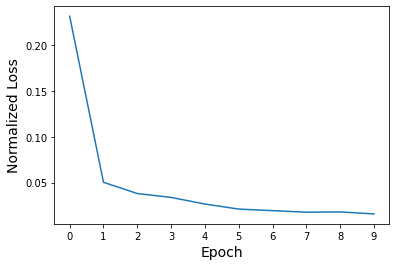

In [0]:
import matplotlib.pyplot as plt
### ACT16 plot the training loss (y-axis) vs epoch number (x-axis)
### using the losses you computed in previous step
plt.plot(range(len(losses)), losses)
_ = plt.xlabel('Epoch', fontsize=14)
_ = plt.ylabel('Normalized Loss', fontsize=14)
_ = plt.xticks(np.arange(0,num_epochs))

plt.show()

### Accuracy of our network on test data
As you will see we will get accuracy of >98% on the test data.

In [0]:
err = 0
tot = 0
with torch.no_grad():
    for data in test_loader:
        # ACT17 retrieve X and y for this batch from data and 
        # move it to GPU (hint: look at what we did in trainer)
        X = data[0].to(device)
        y = data[1].to(device)

        # raw output of network for X
        output = net(X)
        
        # let the maximum index be our predicted class
        _, yh = torch.max(output, 1) 

        # tot will 10,000 at the end, total number of test data
        tot += y.size(0)

        y_np = y.detach().cpu().numpy() 
        yh_np = yh.detach().cpu().numpy()

        num_false = np.sum(y_np != yh_np)

        ## ACT18 add to err number of missclassification, i.e. number of indices that 
        ## yh and y are not equal
        ## note that y and yh are vectors of size = batch_size = (256 in our case)
        err += num_false

print('Accuaracy of prediction on test digits: %5.2f%%' % (100-100 * err / tot))

###ASSERTS
assert((100 - 100 * err / tot) >= 98)
assert(tot == 10 * 1000)

Accuaracy of prediction on test digits: 98.86%


### Visualizing CNN layers

In [0]:
import numpy as np
import matplotlib.pyplot as plt

### function for normalizing a 2d image (input type = numpy 2d array)
def normalize_image(npimg):
    #print(npimg)
    npimg = (npimg - np.mean(npimg)) / np.std(npimg)
    npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
    return npimg

#### Visualizing each filter seperately in the first layer

* Our first layer was a 2d convolutional layer with 32 output channels and 5-by-5 kernel
* Therefore we have 32 different learnt filters each has size (1,5,5) or equivalently each filter is a 5-by-5 array of weights 
* Let's look at this filter as a 5-by-5 grayscale image and plot it


After running this cell, answer the following question:


**ACT19**
**briefly explain what these filters are detecting**


Answer: They are identifying different geometric features that are present when drawing a number and their orientation in space. For example things like: vertical lines, curves in different orientations, parallel lines, etc. Since we are operating on raw pixel data, the features that will be identified by these filters represent very low-level geometric properties

torch.Size([32, 1, 5, 5])


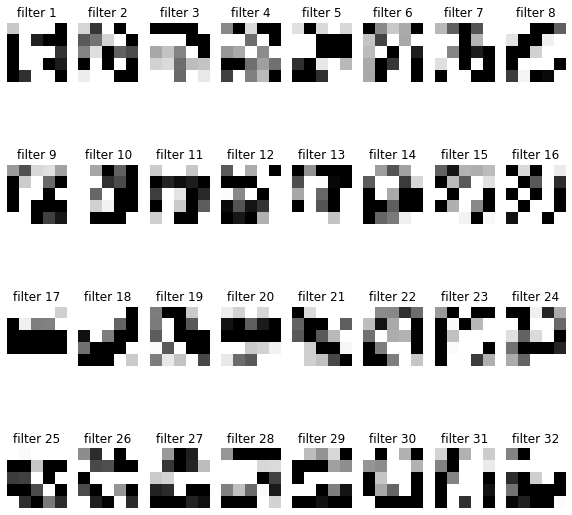

In [0]:
### ACT20
### fill the code below
### hint: start by looking at size of net.conv1.weight 
print(net.conv1.weight.size())

plt.figure(figsize=(10,10))
for i in range(32):
    plt.subplot(4,8,i+1)
    npimg = net.conv1.weight[i].detach().cpu().numpy() #5-by-5 numpy array corresponding to i-th filter 
    npimg = normalize_image(npimg[0])
    plt.imshow(npimg, cmap="gray", vmin=0,vmax=1)
    plt.title("filter " + str(i+1))
    plt.axis("off")
plt.show()


### Visualizing input after applying first layer


*   First layer has 32 filters
*   since padding is 2 and kernel is 5-by-5 each output channel will be agian 28-by-28
* Let's visualize each of these 32 pictures for each of sample digits

After running this cell, answer the following question:

**ACT21**
**briefly explain what these images represent**



Answer: these images represent what "characteristic" of a number is present in the original image, and where in the image it occurs. For example, the resulting images for a number 0 will have patterns showing up from many of the low-level filters that relate to curves.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


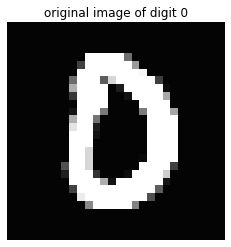

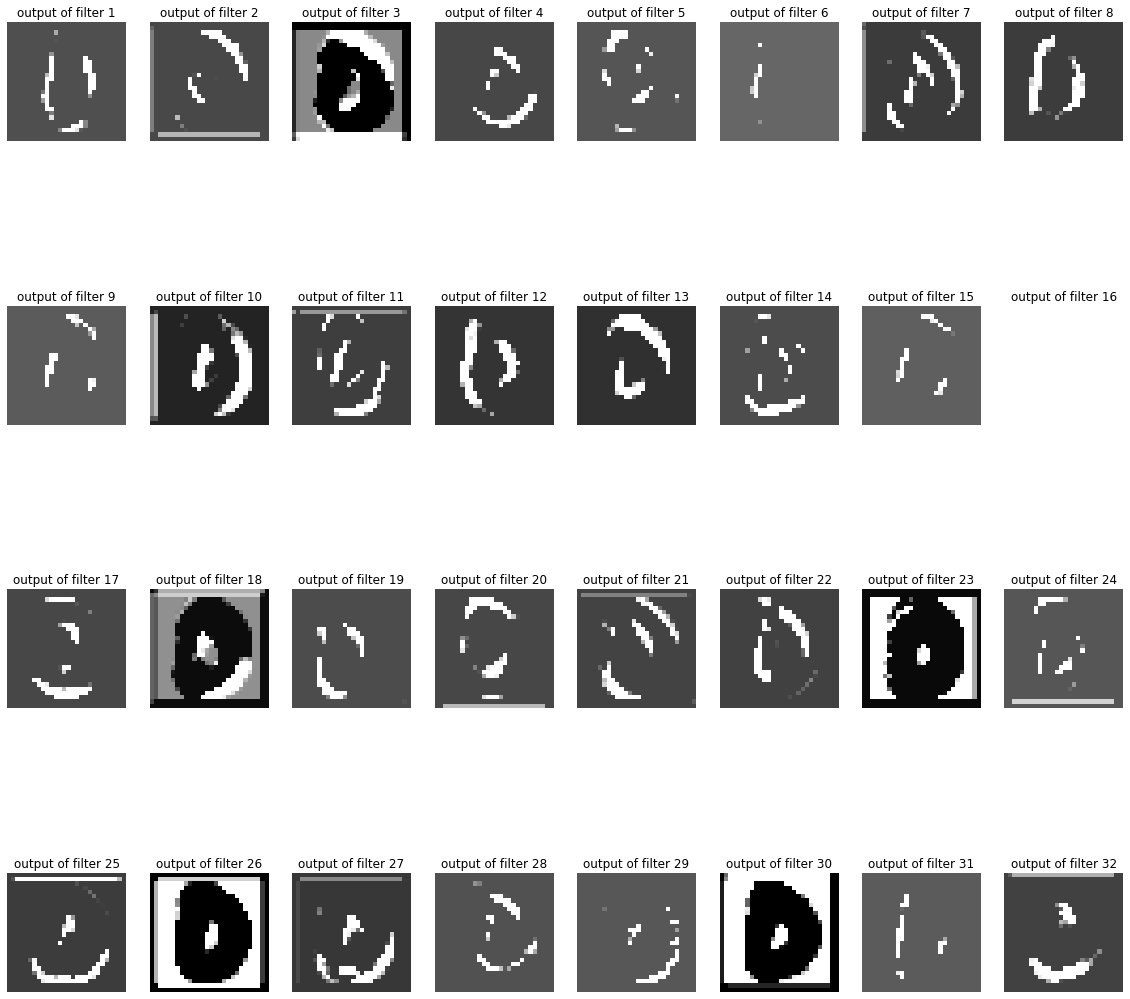

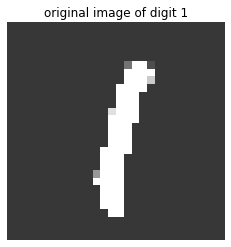

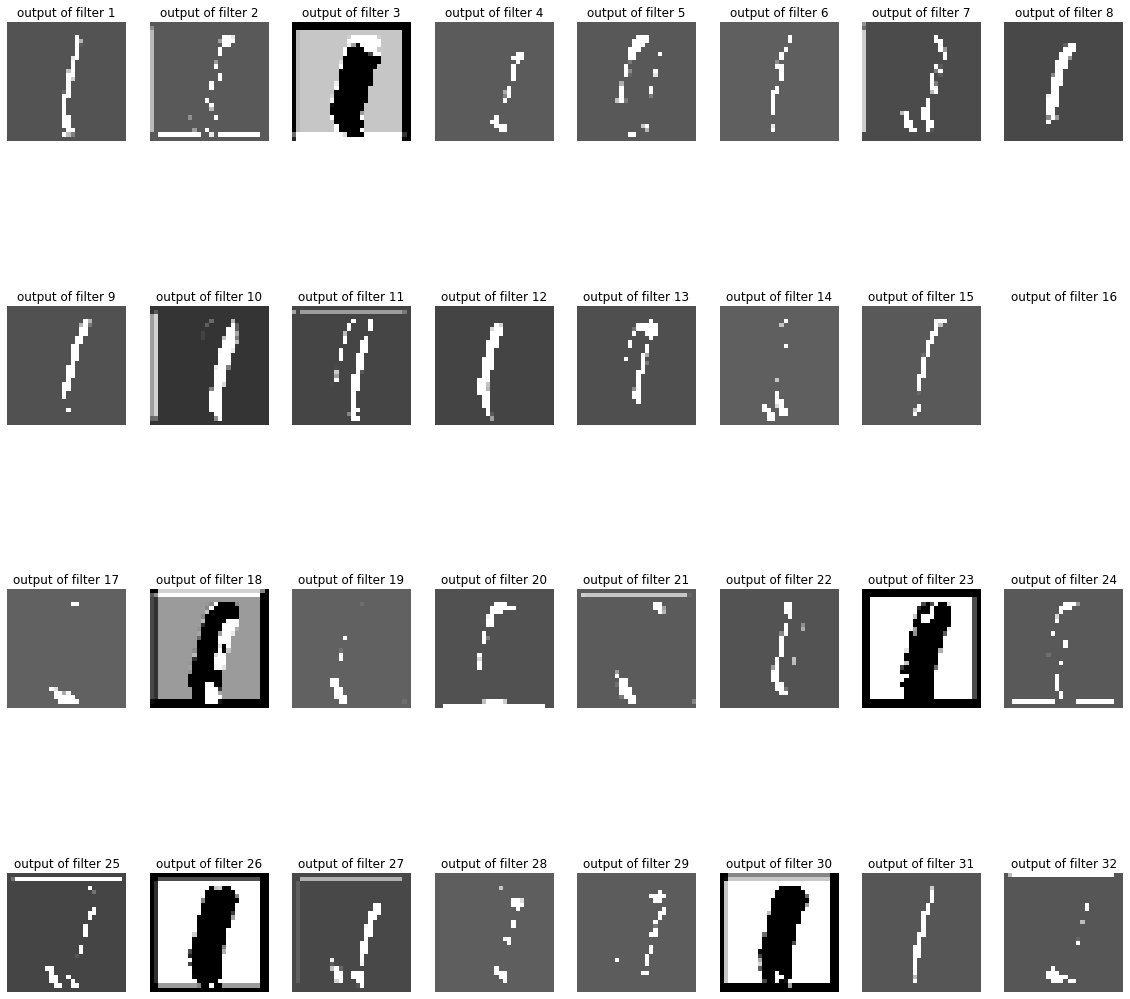

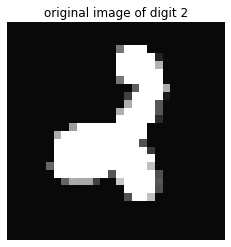

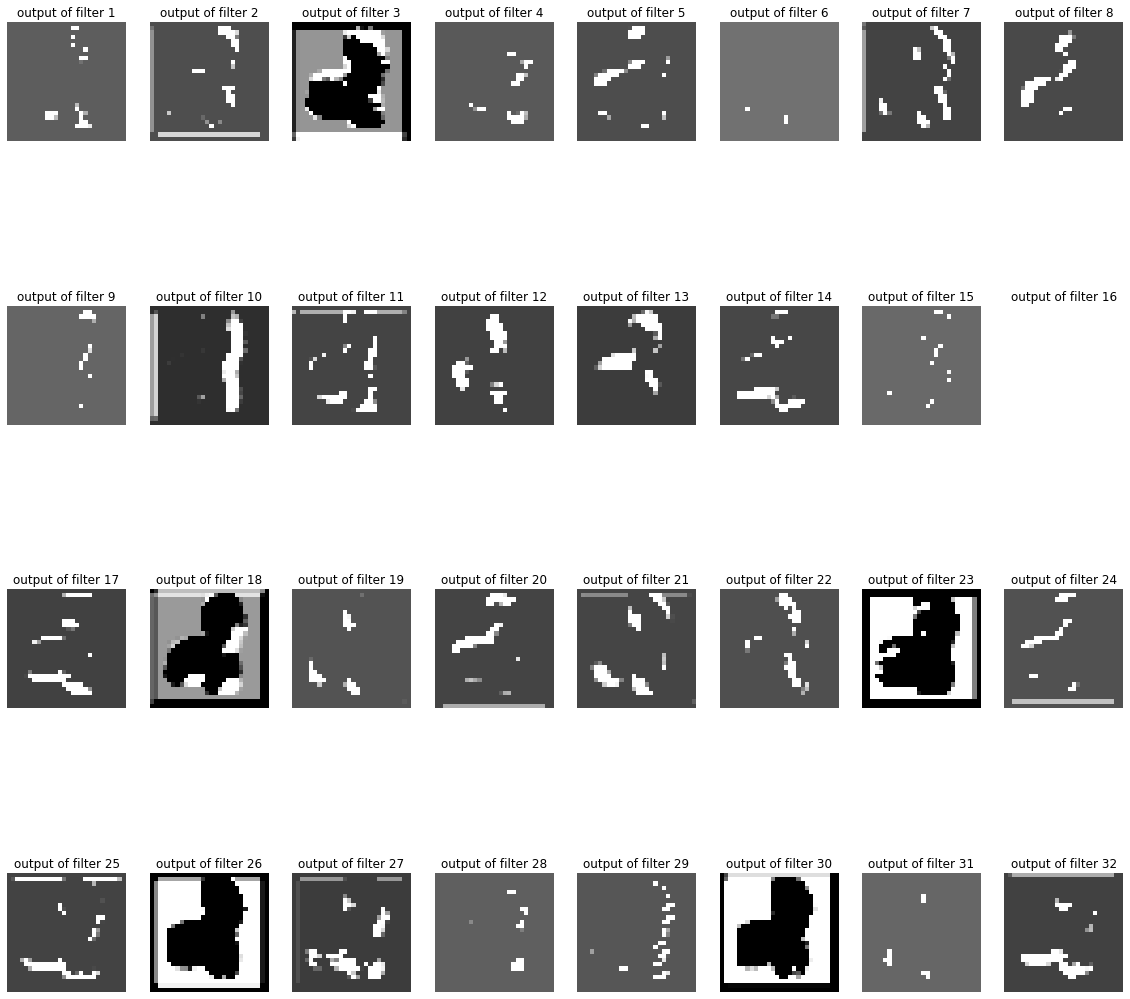

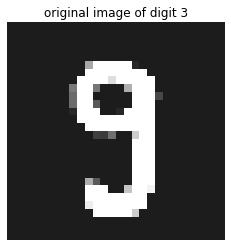

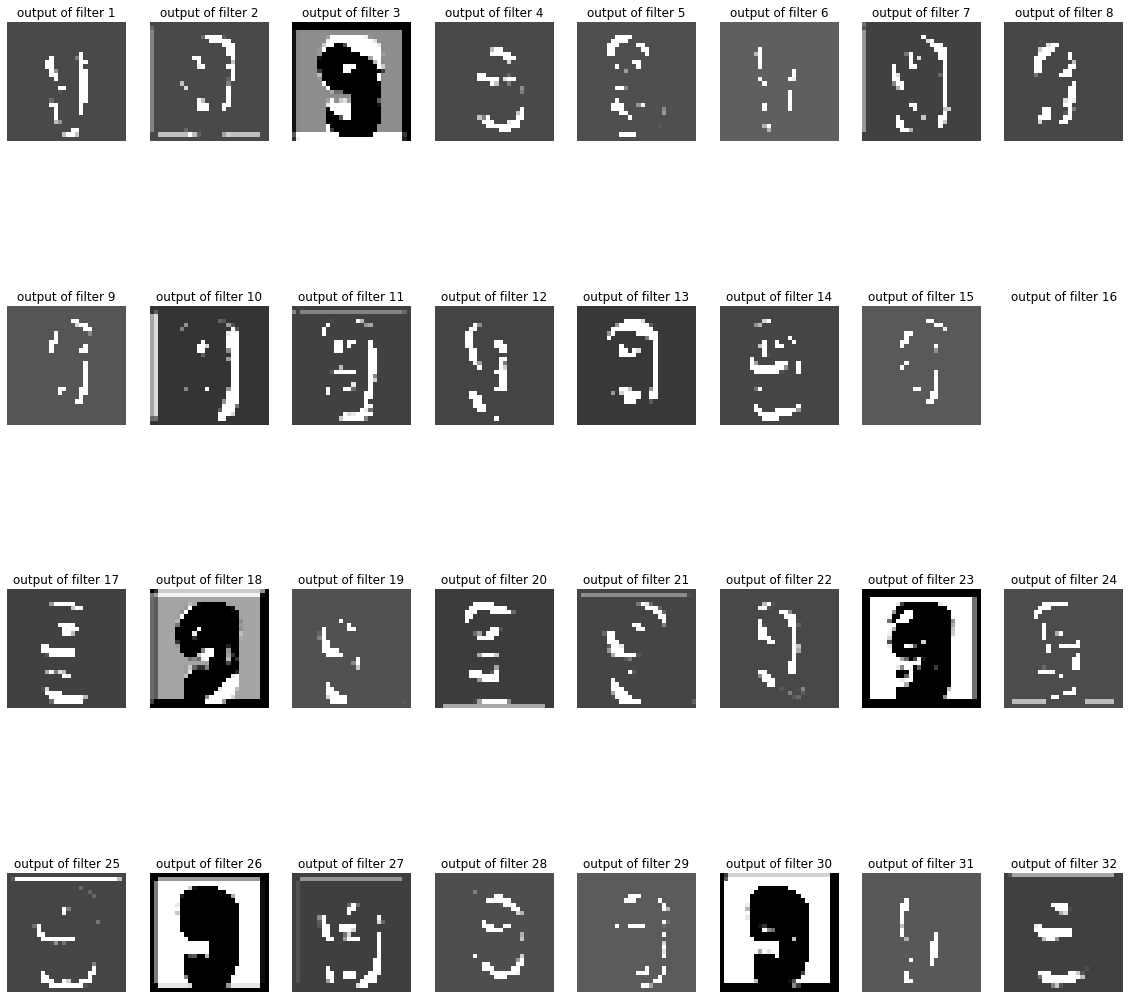

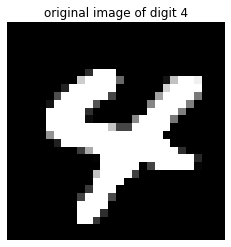

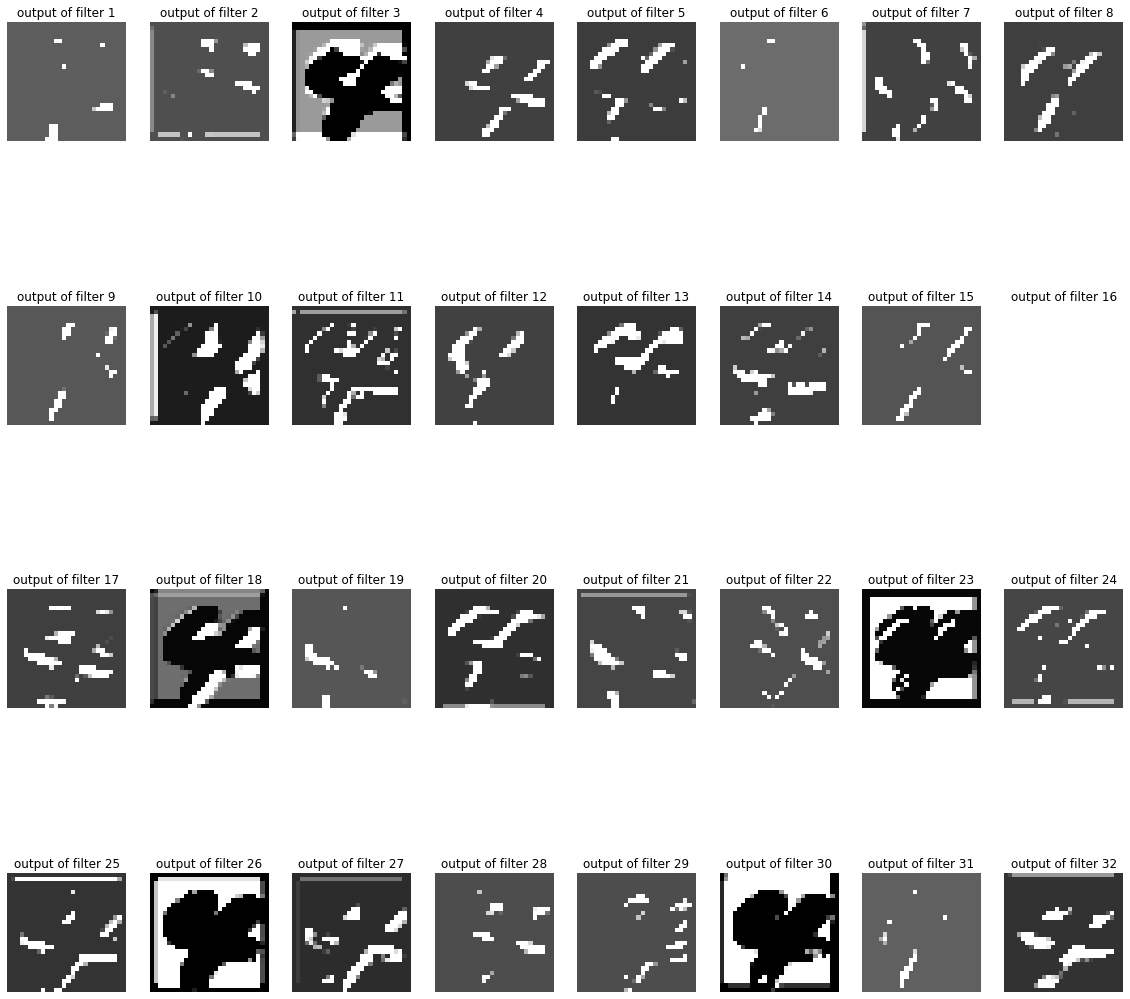

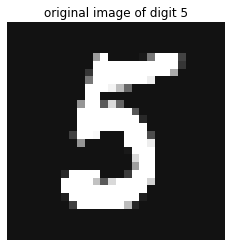

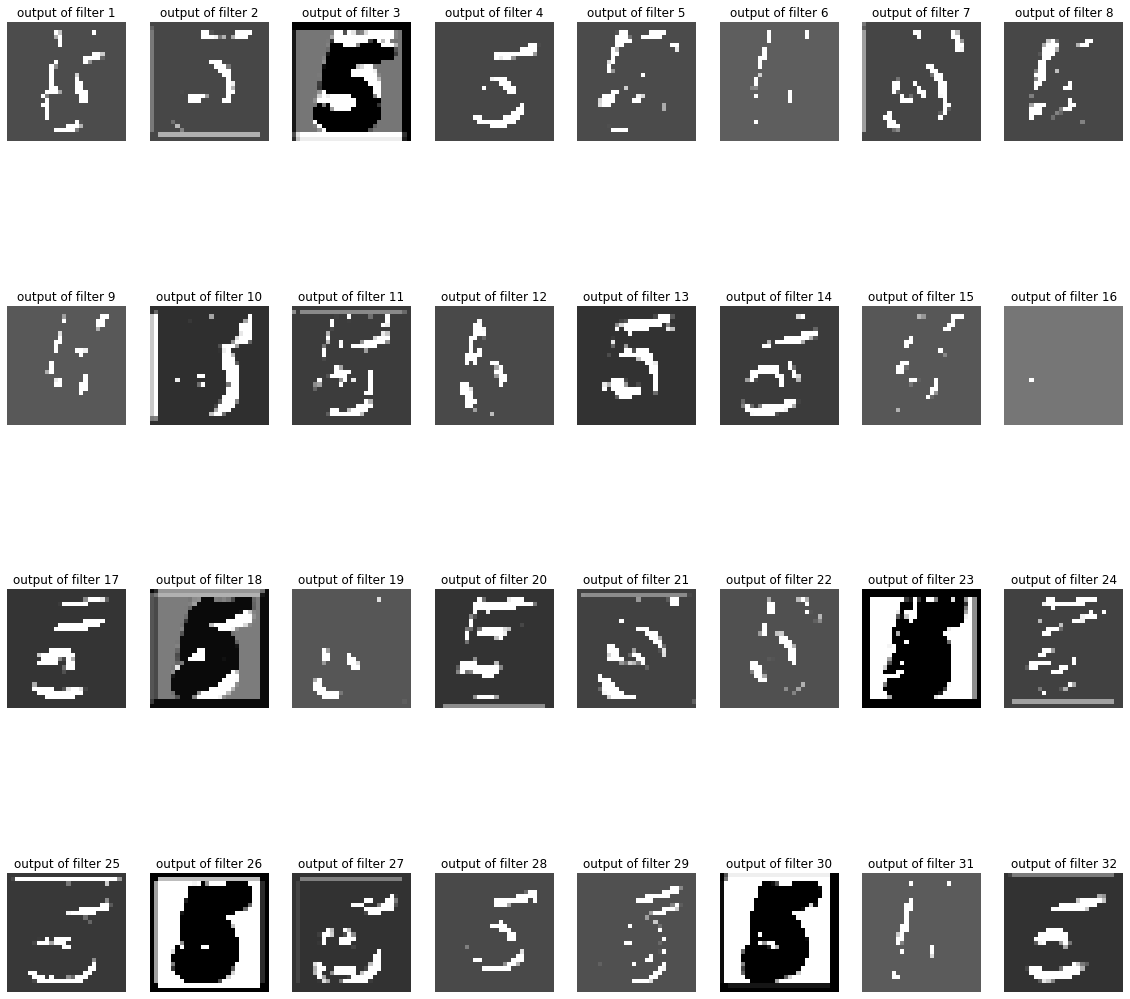

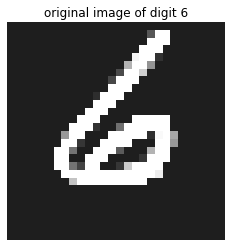

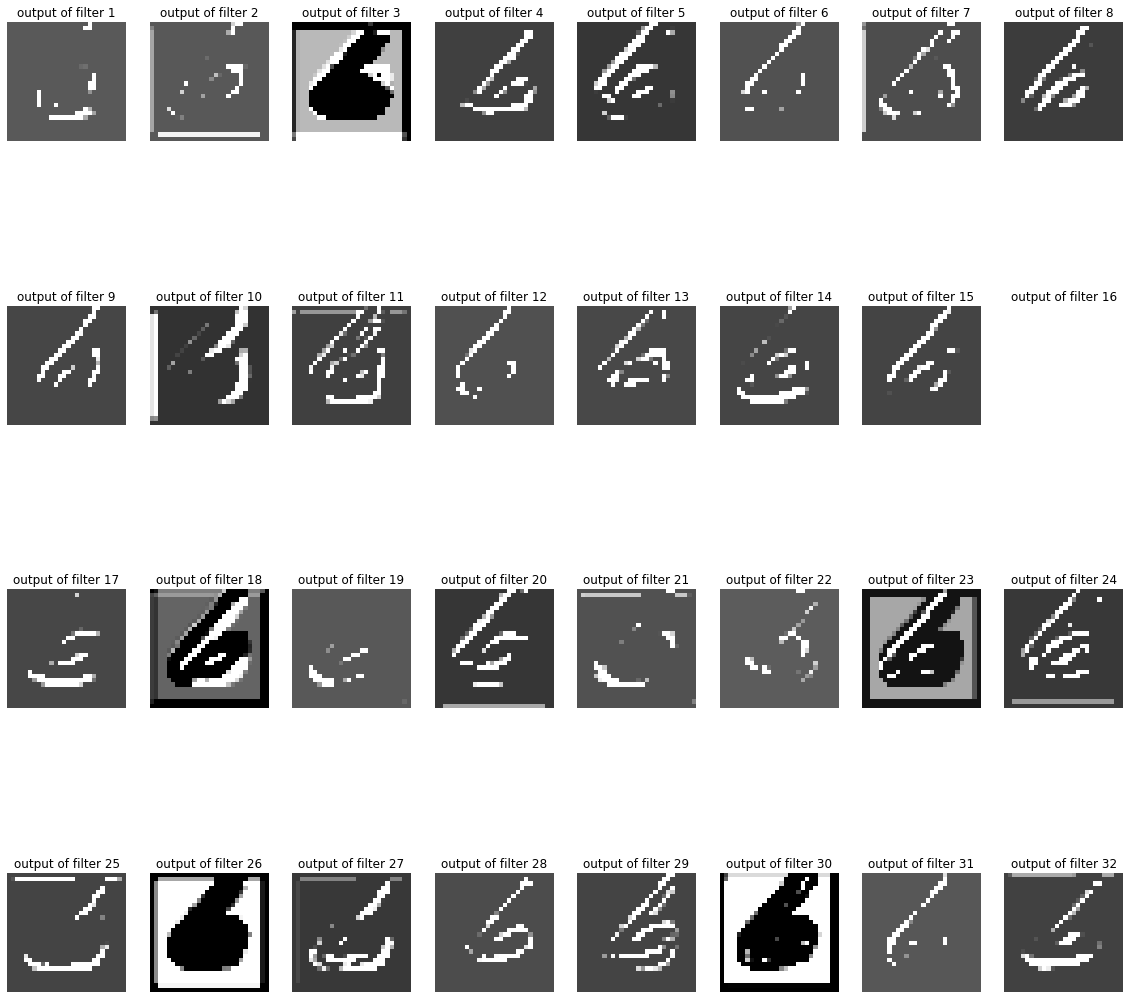

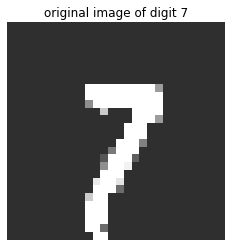

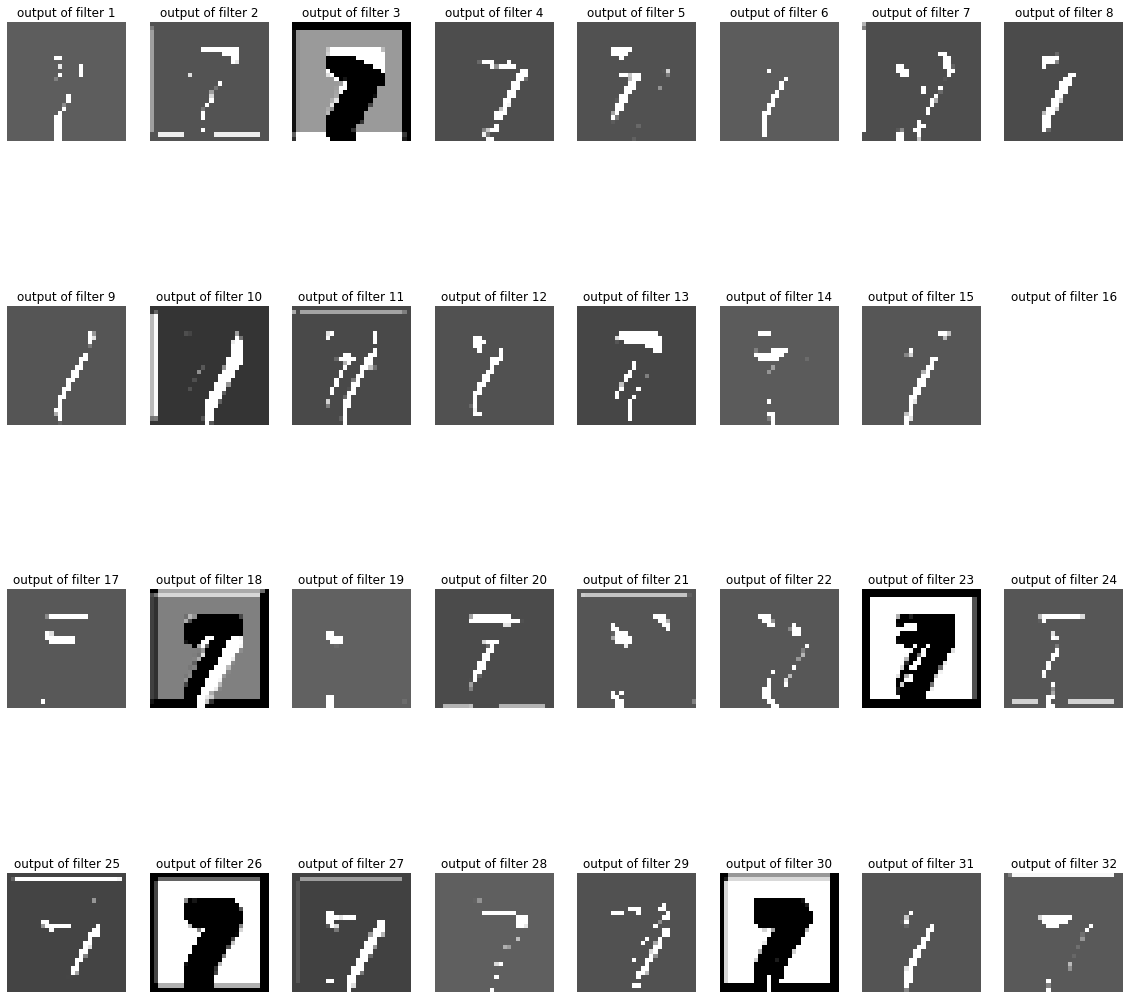

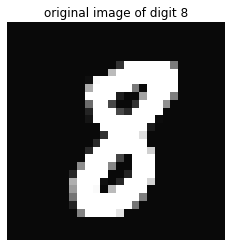

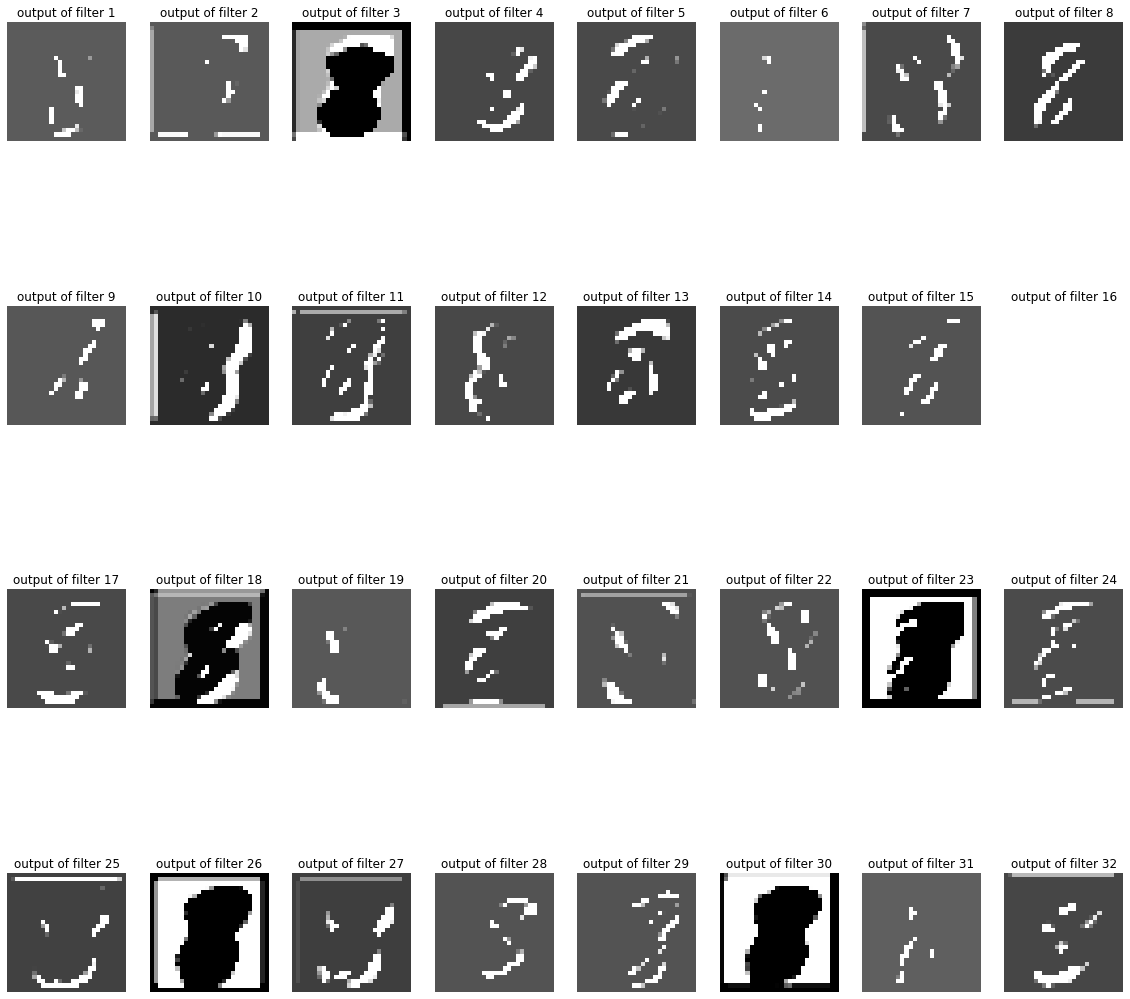

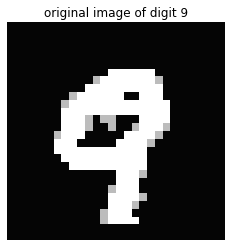

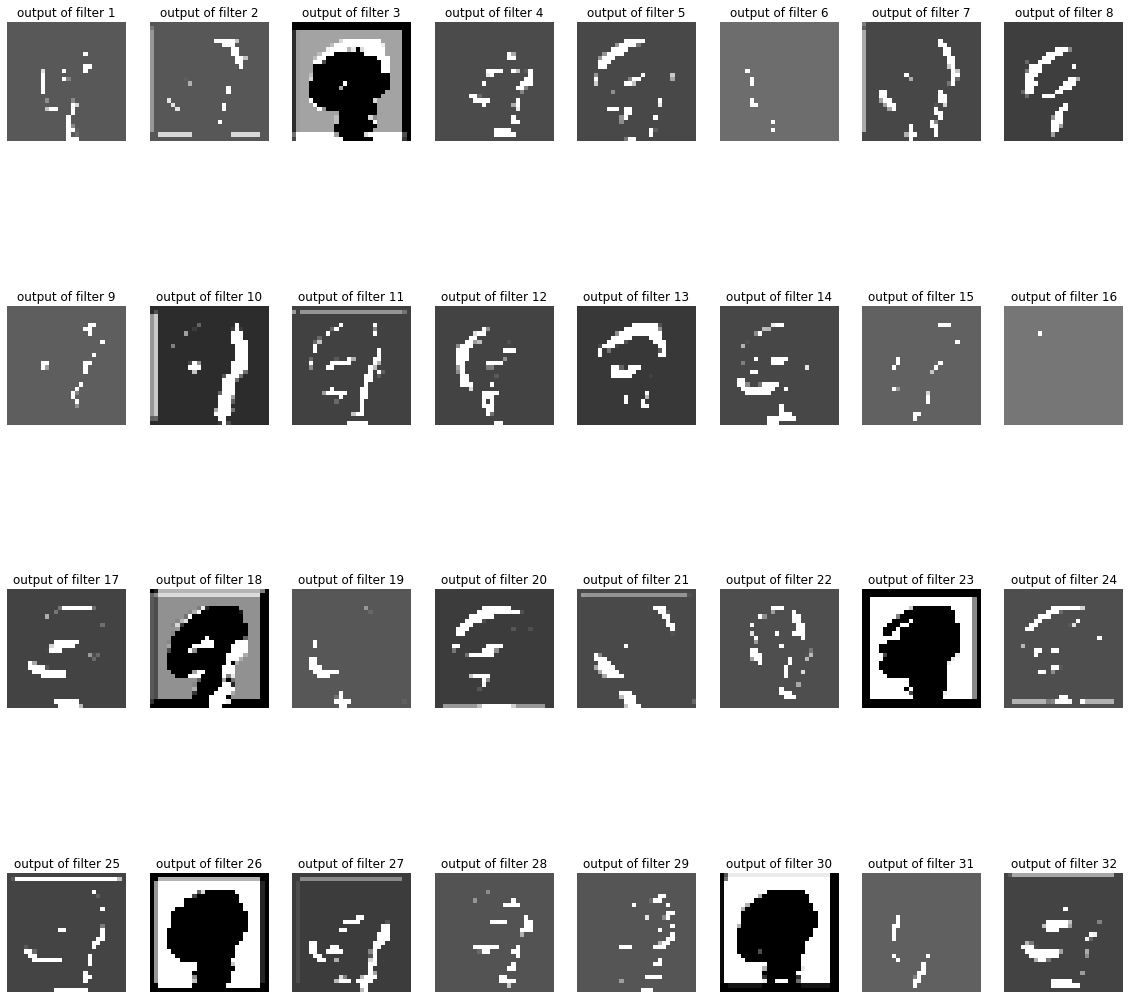

In [0]:

### picking one sample from each label for visualizing purposes
sample_digits = dict()
for data in train_loader:
    for i in range(data[1].shape[0]):
        if data[1][i].item() not in sample_digits.keys():
            sample_digits[data[1][i].item()] = data[0][i]
    if len(sample_digits.keys()) == 10:
        break

    
for digit in range(10):
    plt.figure()
    data = sample_digits[digit]
    npimg = data[0].numpy()
    npimg = normalize_image(npimg)
    plt.imshow(npimg, cmap="gray", vmin=0, vmax=1)
    plt.title("original image of digit %d"%digit)
    plt.axis("off")
    plt.figure(figsize=(20, 20))
    
    with torch.no_grad():
        data = data.unsqueeze(0).to(device)
        ### ACT22
        ### data has shape (1,1,28,28)
        ### pass the data to only layer conv1 and apply RELU activation (do not apply maxpooling)
        ### the output should be tensor of size (1,32,28,28)
        output = F.relu(net.conv1(data))
    
    data_numpy = output.detach().cpu().numpy()
    for i in range(32):
        plt.subplot(4, 8, i + 1)
        npimg = data_numpy[0,i]
        npimg=normalize_image(npimg)
        plt.imshow(npimg, cmap="gray", vmin=0, vmax=1)
        plt.title("output of filter " + str(i + 1))
        plt.axis("off")
    plt.show()
    
    ###ASSERTS
    assert(data.size()==(1, 1, 28, 28))
    assert(output.size()==(1, 32, 28, 28))